In [44]:
# Cell 1: Imports, utils và tạo thư mục đầu ra
import os
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,6)

# Tạo thư mục lưu ảnh
os.makedirs('outputs', exist_ok=True)

# --- Hàm tiện ích ---
def gaussian_kernel(size, sigma):
    ax = np.arange(-(size//2), size//2+1)
    xx, yy = np.meshgrid(ax, ax)
    K = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    return K / K.sum()

# Cell 2: Các hàm tiện ích

def gaussian_kernel(size, sigma):
    """Tạo kernel Gaussian vuông kích thước `size` và độ lệch chuẩn `sigma`."""
    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    return kernel / kernel.sum()

def conv2d_fft(image, kernel):
    """Chập 2D bằng FFT: pad kernel về kích thước ảnh, nhân FFT rồi ifft."""
    im_h, im_w = image.shape
    k_h, k_w = kernel.shape
    # pad kernel vào góc trên bên trái của mảng cùng kích thước
    pad = np.zeros_like(image)
    pad[:k_h, :k_w] = kernel
    # chuyển kernel sao cho tâm ở góc (fftshift)
    H = fft2(fftshift(pad))
    G = fft2(image)
    return np.real(ifft2(H * G))


def add_gaussian_noise(image, sigma):
    """Thêm nhiễu Gaussian với độ lệch chuẩn sigma."""
    noisy = image + np.random.normal(0, sigma, size=image.shape)
    return np.clip(noisy, 0, 1)

def psnr(target, ref):
    """Tính PSNR giữa hai ảnh (giả sử pixel đã chuẩn về [0,1])."""
    mse = np.mean((target - ref)**2)
    if mse == 0:
        return np.inf
    return 10 * np.log10(1.0 / mse)


def add_noise_psnr(img, target_db):
    # var = 10^(-PSNR/10)
    var = 10**(-target_db/10)
    noise = np.random.normal(0, np.sqrt(var), img.shape)
    return np.clip(img + noise, 0, 1)

def psnr(a, b):
    mse = np.mean((a - b)**2)
    return float('inf') if mse == 0 else 10 * np.log10(1.0 / mse)

def conv2d_spatial(image, kernel):
    """
    Chập 2D bằng thuật toán spatial convolution:
     - image: 2D numpy array (H,W)
     - kernel: 2D numpy array (h,w), đã được normalize sum=1
    """
    H, W = image.shape
    h, w = kernel.shape
    pad_h, pad_w = h//2, w//2
    
    # pad image bằng giá trị 0 ở biên
    padded = np.pad(image, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    
    out = np.zeros_like(image)
    # nested loops
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+h, j:j+w]
            out[i,j] = np.sum(patch * kernel)
    return out


# --- Deconvolution methods ---
def wiener_filter(noisy, kernel, K=1e-3):
    pad = np.zeros_like(noisy)
    kh, kw = kernel.shape
    pad[:kh, :kw] = kernel
    pad = fftshift(pad)
    Hf = fft2(pad)
    G  = fft2(noisy)
    F  = np.conj(Hf) / (np.abs(Hf)**2 + K) * G
    return np.real(ifft2(F))

def tikhonov_filter(noisy, kernel, alpha=1e-3):
    pad = np.zeros_like(noisy)
    kh, kw = kernel.shape
    pad[:kh, :kw] = kernel
    pad = fftshift(pad)
    Hf = fft2(pad)
    G  = fft2(noisy)
    F  = np.conj(Hf) / (np.abs(Hf)**2 + alpha) * G
    return np.real(ifft2(F))

def richardson_lucy_spatial(obs, kernel, iters=30):
    """
    Richardson–Lucy deconvolution thuần spatial (không qua FFT).
    """
    H, W = obs.shape
    # khởi tạo f với giá trị trung bình
    f = np.full_like(obs, obs.mean())
    # kernel đảo
    krev = kernel[::-1, ::-1]

    for i in range(iters):
        # forward conv
        estimate = conv2d_spatial(f, kernel)
        # tránh chia 0
        ratio = obs / np.maximum(estimate, 1e-6)
        # backward conv
        correction = conv2d_spatial(ratio, krev)
        # update
        f *= correction
        # giữ [0,1]
        f = np.clip(f, 0, 1)
    return f



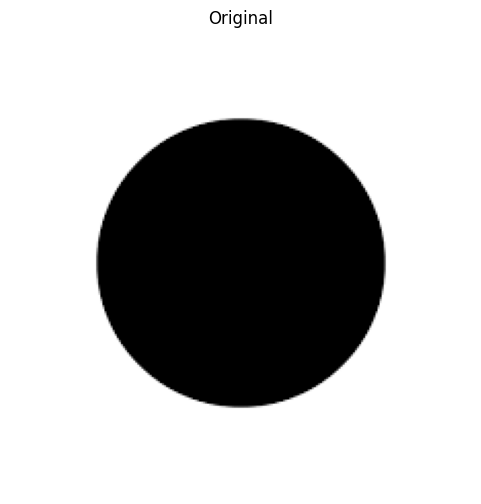

In [45]:
# Cell 2: Load ảnh gốc, chuẩn hoá và lưu
img = Image.open('images.png').convert('L')
orig = np.asarray(img, dtype=float) / 255.0

plt.imshow(orig, cmap='gray')
plt.axis('off')
plt.title('Original')
plt.savefig('outputs/original.png', bbox_inches='tight', pad_inches=0,dpi = 300)


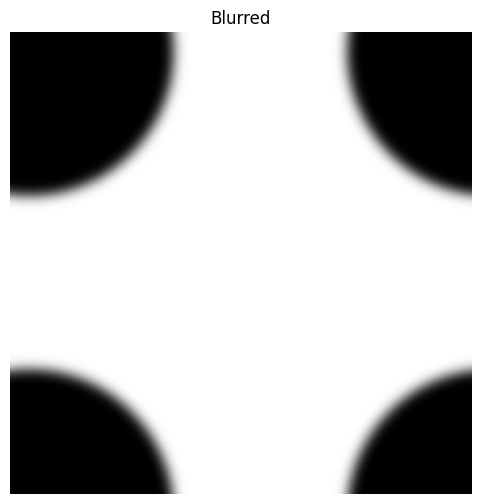

In [46]:
# Cell 3: Blur ảnh và lưu
kernel = gaussian_kernel(size=21, sigma=3)
blurred = conv2d_fft(orig, kernel)

plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.title('Blurred')
plt.savefig('outputs/blurred.png', bbox_inches='tight', pad_inches=0, dpi = 300)


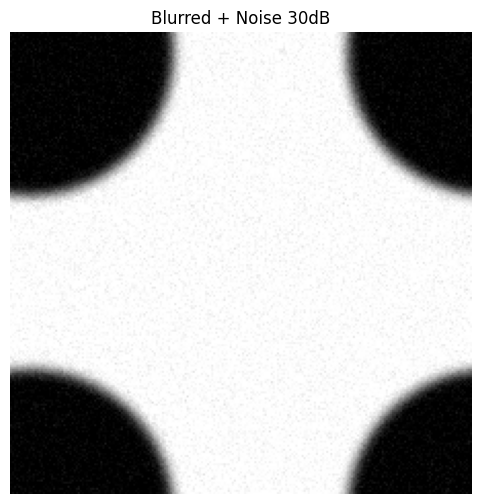

In [47]:
# Cell 4: Tạo các ảnh noisy ở nhiều mức PSNR rồi lưu
psnr_levels = [10, 20, 25, 30]
noisy_images = {}
for db in psnr_levels:
    noisy = add_noise_psnr(blurred, db)
    noisy_images[db] = noisy
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')
    plt.title(f'Blurred + Noise {db}dB')
    plt.savefig(f'outputs/noisy_{db}dB.png', bbox_inches='tight', pad_inches=0, dpi = 300)


In [48]:
# Cell 5.1: Ước lượng K (Wiener) và α (Tikhonov) cho từng mức noise
param_est = {}
alphas = np.logspace(-6, -1, 50)

for db, noisy in noisy_images.items():
    noise_var  = np.var(noisy - blurred)
    signal_var = max(np.var(blurred) - noise_var, 1e-12)
    K_est      = noise_var / signal_var

    MN     = orig.size
    target = MN * noise_var
    best_a, best_diff = alphas[0], float('inf')
    for a in alphas:
        rec_tik = tikhonov_filter(noisy, kernel, alpha=a)
        reblur  = conv2d_spatial(rec_tik, kernel)
        res     = np.sum((reblur - noisy)**2)
        diff    = abs(res - target)
        if diff < best_diff:
            best_diff, best_a = diff, a

    param_est[db] = {'K': K_est, 'alpha': best_a}
    print(f"Noise {db}dB:  K_est = {K_est:.2e},   α_est = {best_a:.2e}")


Noise 10dB:  K_est = 3.26e-01,   α_est = 1.00e-01
Noise 20dB:  K_est = 2.68e-02,   α_est = 1.00e-01
Noise 25dB:  K_est = 8.51e-03,   α_est = 1.00e-01
Noise 30dB:  K_est = 2.70e-03,   α_est = 1.00e-01


In [49]:
# Cell 6.1: Áp dụng deconv với tham số ước lượng, lưu ảnh & in PSNR
results_est = {}
for db, noisy in noisy_images.items():
    K_est   = param_est[db]['K']
    alpha   = param_est[db]['alpha']

    rec_w   = wiener_filter(noisy, kernel,    K=K_est)
    rec_t   = tikhonov_filter(noisy, kernel, alpha=alpha)
    rec_rl  = richardson_lucy(noisy, kernel,  iters=30)

    # lưu ảnh
    plt.imsave(f'outputs/wiener_est_{db}dB.png',   rec_w, cmap='gray', dpi = 300)
    plt.imsave(f'outputs/tikhonov_est_{db}dB.png', rec_t, cmap='gray', dpi = 300)
    plt.imsave(f'outputs/rl_est_{db}dB.png',       rec_rl, cmap='gray', dpi = 300)

    # tính & in PSNR
    ps_w  = psnr(rec_w, orig)
    ps_t  = psnr(rec_t, orig)
    ps_rl = psnr(rec_rl, orig)
    print(f"Noise {db}dB | Wiener (K={K_est:.2e}) PSNR={ps_w:.2f}dB | "
          f"Tikhonov (α={alpha:.2e}) PSNR={ps_t:.2f}dB | RL PSNR={ps_rl:.2f}dB")

    results_est[db] = {'wiener':(rec_w,ps_w),
                       'tikhonov':(rec_t,ps_t),
                       'rl':(rec_rl,ps_rl)}


Noise 10dB | Wiener (K=3.26e-01) PSNR=10.57dB | Tikhonov (α=1.00e-01) PSNR=14.10dB | RL PSNR=3.09dB
Noise 20dB | Wiener (K=2.68e-02) PSNR=21.54dB | Tikhonov (α=1.00e-01) PSNR=18.17dB | RL PSNR=2.45dB
Noise 25dB | Wiener (K=8.51e-03) PSNR=23.51dB | Tikhonov (α=1.00e-01) PSNR=19.09dB | RL PSNR=2.30dB
Noise 30dB | Wiener (K=2.70e-03) PSNR=24.33dB | Tikhonov (α=1.00e-01) PSNR=19.61dB | RL PSNR=2.22dB
